In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import shap

## Preprocessing the {Pt, Pd, Au, Ir} Features and Tafel Slope Target

                 Min       Max
Pt           0.03120  0.652500
Pd           0.05360  0.555100
Au           0.03140  0.699500
Ir           0.00090  0.729800
Tafel slope  0.10836  1.095058


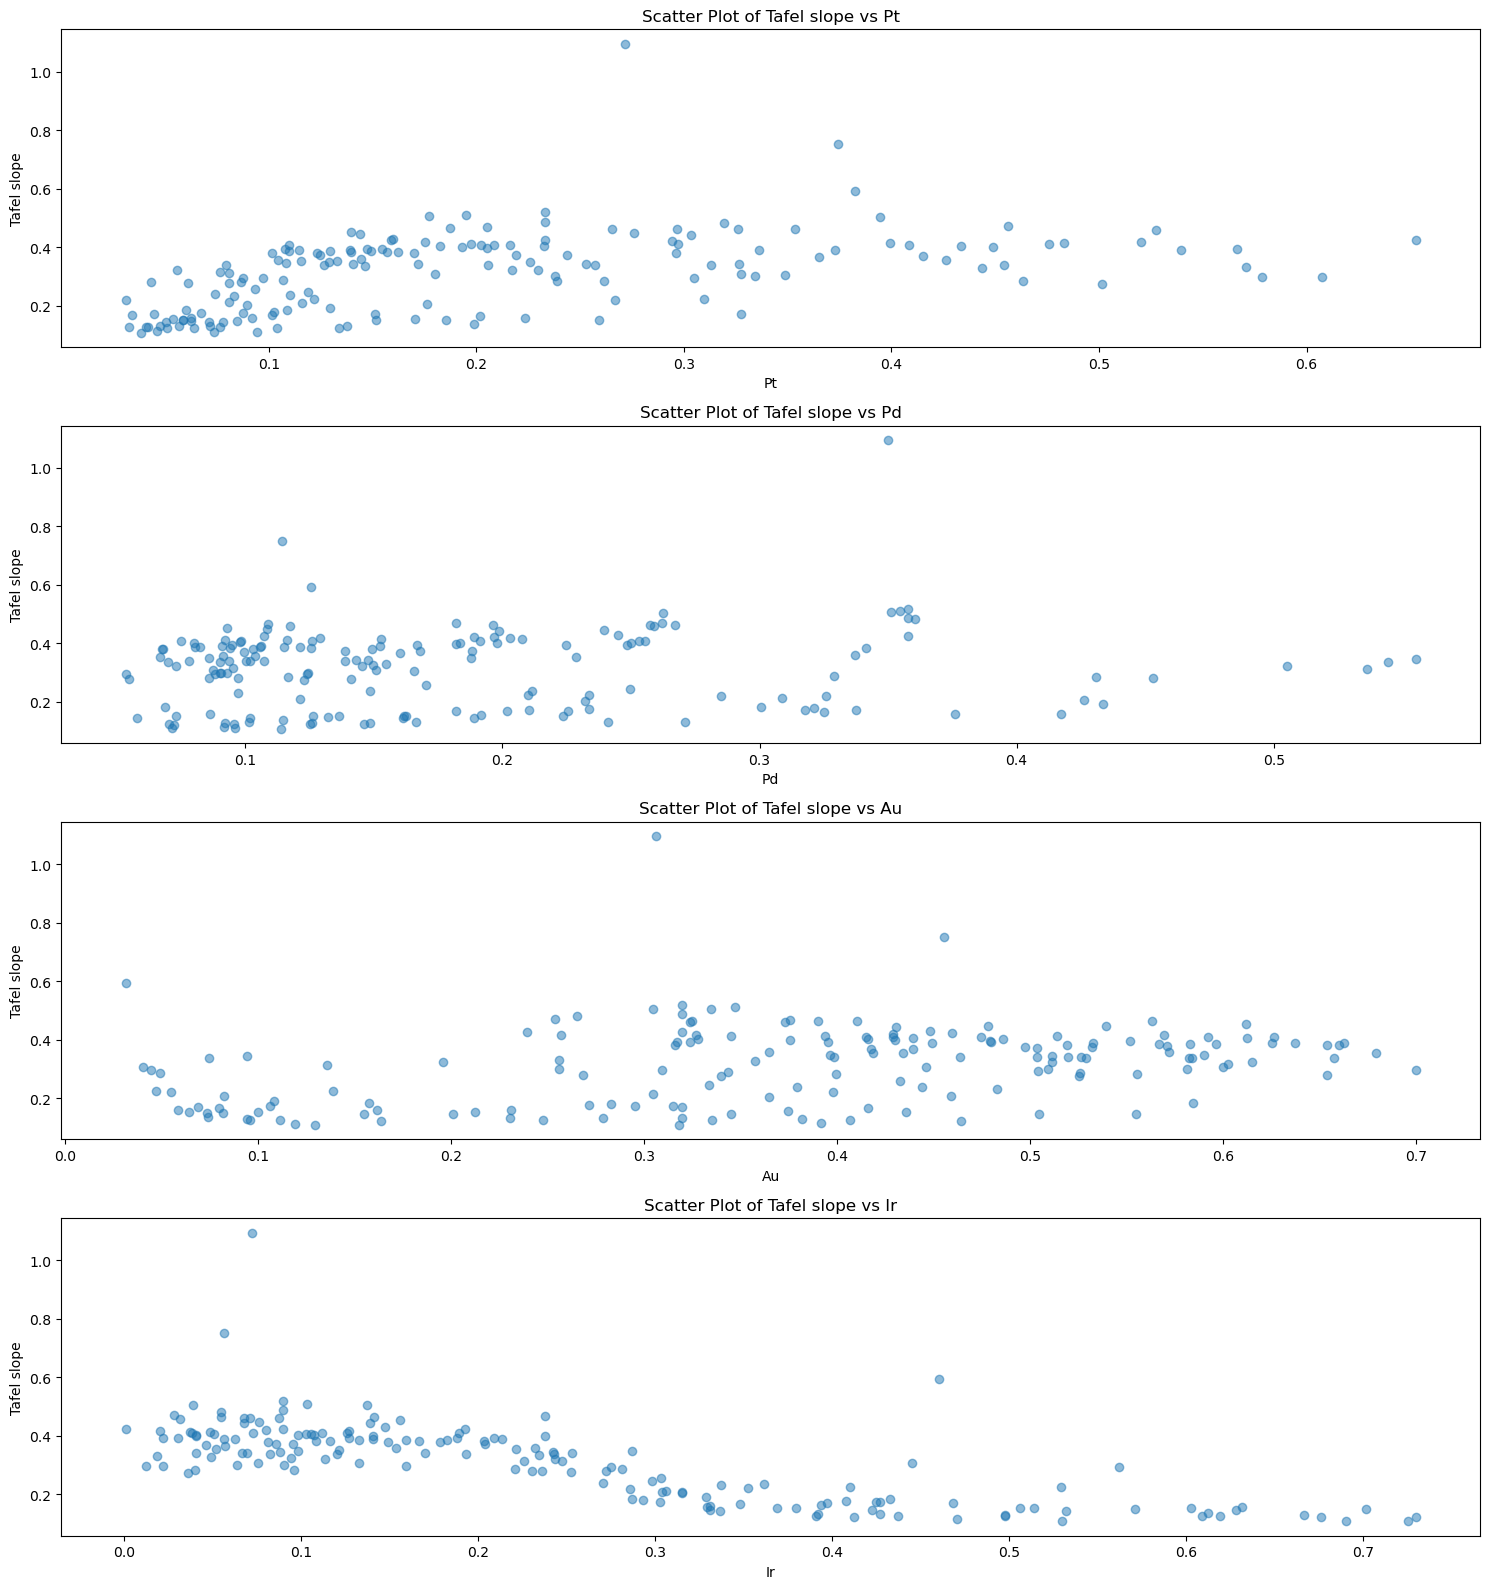

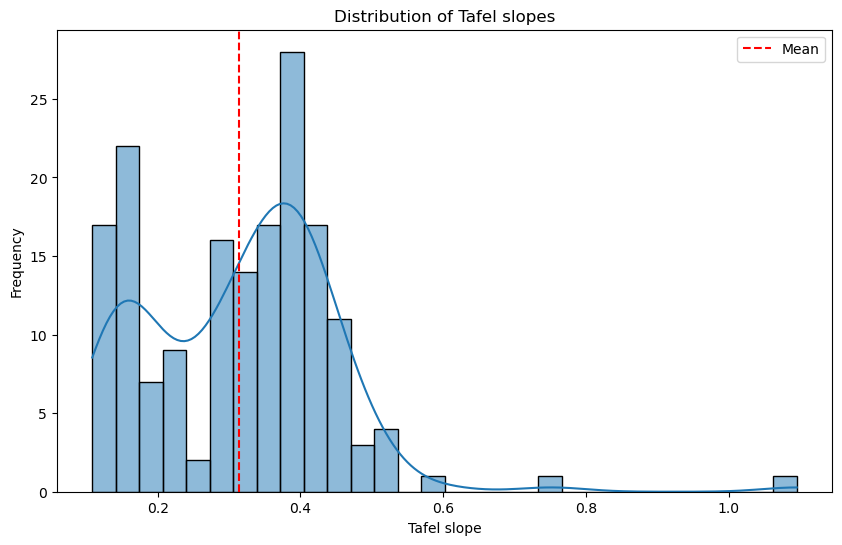


Tafel Data
         Pt      Pd      Au      Ir  Tafel slope
0    0.1375  0.1015  0.0940  0.6670     0.130046
1    0.3487  0.1658  0.0403  0.4453     0.305859
2    0.3742  0.1144  0.4550  0.0564     0.751627
3    0.1330  0.0667  0.6788  0.1215     0.352967
4    0.1544  0.1669  0.5517  0.1270     0.394428
..      ...     ...     ...     ...          ...
165  0.0603  0.0688  0.5840  0.2869     0.184172
166  0.1704  0.2235  0.0999  0.5062     0.153247
167  0.0586  0.1262  0.2125  0.6028     0.152257
168  0.0411  0.0921  0.2475  0.6193     0.126723
169  0.1157  0.2288  0.4342  0.2213     0.354110

[170 rows x 5 columns]


In [2]:
comp_tafel_df = pd.read_csv('composition_Tafel.csv')
features = ['Pt', 'Ir', 'Au', 'Pd']
#Drop any rows that have only NaN values
comp_tafel_df = comp_tafel_df[~(comp_tafel_df['Pt'].isna() & comp_tafel_df['Tafel slope'].isna())]

#Impute composition data using mean values. Impute Tafel slope below current density threshold with max(slope).
imputer = SimpleImputer(strategy='mean')
columns_to_impute = comp_tafel_df.drop(columns=['Tafel slope']) #All columns except Tafel slope
imputed_df = pd.DataFrame(imputer.fit_transform(columns_to_impute), index=columns_to_impute.index, \
                          columns=columns_to_impute.columns)
comp_tafel_df = pd.concat([imputed_df, comp_tafel_df[['Tafel slope']]], axis=1)
comp_tafel_df['Tafel slope'] = comp_tafel_df['Tafel slope'].fillna(comp_tafel_df['Tafel slope'].max())

#Column Ranges
min_max_df = pd.DataFrame({'Min': comp_tafel_df.min(), 'Max': comp_tafel_df.max()})
print(min_max_df)

#Noble metal vs Tafel slope
target = 'Tafel slope'
features = [col for col in comp_tafel_df.columns if col != target]
plt.figure(figsize=(15, len(features) * 4))
for i, feature in enumerate(features, 1):
    plt.subplot(len(features), 1, i)
    plt.scatter(comp_tafel_df[feature], comp_tafel_df[target], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.title(f'Scatter Plot of {target} vs {feature}')
plt.tight_layout()
plt.savefig('tafelslope_metals.png', dpi=300)
plt.show()

#Statistical analysis of Tafel slope distributions
plt.figure(figsize=(10, 6))
sns.histplot(comp_tafel_df['Tafel slope'], bins=30, kde=True)
plt.title('Distribution of Tafel slopes')
plt.xlabel('Tafel slope')
plt.ylabel('Frequency')
plt.axvline(x=comp_tafel_df['Tafel slope'].mean(), color='red', linestyle='--', label='Mean')
plt.legend()
plt.savefig('dist_tafelslopes.png', dpi=300)
plt.show()

print('\nTafel Data')
print(comp_tafel_df)
X = comp_tafel_df.drop(columns=['Tafel slope'])
y = comp_tafel_df['Tafel slope']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## GB Regressor Model and Hyperparameter Tuning (Full Dataset)

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 100}
Gradient Boosting MSE on Training Set: 0.00013700219283942555
Gradient Boosting MSE on Test Set: 0.011835941025304572
Baseline MSE: 0.018098866362725403
Percentage Improvement: 34.60%
NOTE: A reduction of at least 20-30% in MSE compared to the baseline is
often considered a reasonable improvement for many applications.
34.6% suggests it has captured significant patterns beyond the baseline.


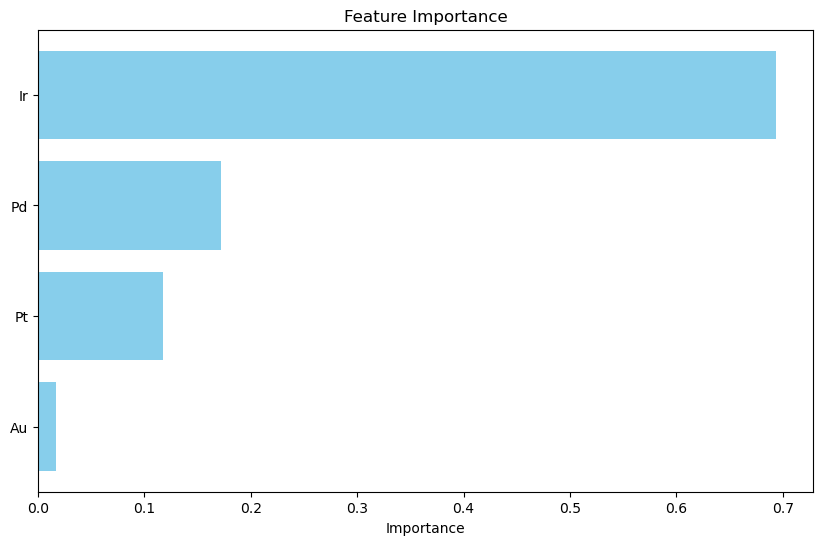

In [3]:
gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    'n_estimators': list(range(20, 200, 20)),
    'learning_rate': [0.01, 0.05, 0.1],
}
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
best_gbr = grid_search.best_estimator_
print("Gradient Boosting MSE on Training Set:", mean_squared_error(y_train, best_gbr.predict(X_train)))
gb_test_mse = mean_squared_error(y_test, best_gbr.predict(X_test))
print("Gradient Boosting MSE on Test Set:", gb_test_mse)
baseline_pred = np.mean(y_train)
baseline_mse = mean_squared_error(y_test, [baseline_pred] * len(y_test))
print("Baseline MSE:", baseline_mse)
percentage_improvement = ((baseline_mse - gb_test_mse) / baseline_mse) * 100
print(f"Percentage Improvement: {percentage_improvement:.2f}%")
print("""NOTE: A reduction of at least 20-30% in MSE compared to the baseline is
often considered a reasonable improvement for many applications.
34.6% suggests it has captured significant patterns beyond the baseline.""")

feature_importances = best_gbr.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

## SHAP Dependence Plot on the dominant feature (Ir)

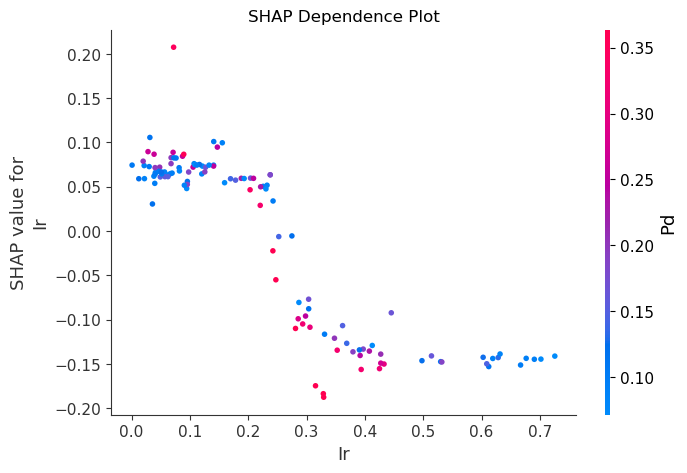

NOTE: Higher positive SHAP values indicate that the feature pushes the
prediction higher, while negative SHAP values mean the feature pushes the prediction lower.
Ir < 30% yields greater Tafel slopes.
Ir > 30% yields small Tafel slopes.
Based on the feature importance above, it is clear that Ir > 30% is necessary to lower
Tafel slopes and thus improve the kinetics for the quarternary catalysts examined.
The random color of the feature on the right indicates that there are no other
important considerations to be found.


In [4]:
explainer = shap.Explainer(best_gbr, X_train)
shap_values = explainer(X_train)
shap.dependence_plot('Ir', shap_values.values, X_train, show=False)
plt.title('SHAP Dependence Plot')
plt.savefig('shap_dependence_plot_Ir.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("""NOTE: Higher positive SHAP values indicate that the feature pushes the
prediction higher, while negative SHAP values mean the feature pushes the prediction lower.
Ir < 30% yields greater Tafel slopes.
Ir > 30% yields small Tafel slopes.
Based on the feature importance above, it is clear that Ir > 30% is necessary to lower
Tafel slopes and thus improve the kinetics for the quarternary catalysts examined.
The random color of the feature on the right indicates that there are no other
important considerations to be found.""")